# Отток клиентов: Сегментация

<b>Задача:</b>
Необходимо проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов

<b>Цель:</b> Сформулировать рекоммендации для отедла маркетинга для предотвращение оттока клиентов

## Предобработка данных

### Получение дата-сета и вывод информации о нем



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
color_palette = sns.color_palette("pastel")

In [23]:
df = pd.read_csv('/datasets/bank_scrooge.csv')

Колонки:
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — оценочный доход клиента,
- сhurn — признак оттока.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

In [24]:
df = df.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'})

### Поиск дубликатов
- Удаление явных дубликатов при их наличии

In [25]:
df.duplicated().sum()

0

In [26]:
df['user_id'].duplicated().sum()

73

In [27]:
df = df.drop_duplicates(subset='user_id')

В дата сете не было обнаружено явных дубликатов, но в столбце user_id их было 73. Дубликаты по user_id были удалены

### Поиск и анализ пропущенных значений
- Выявление причин возникновения пропусков
- Рассмотрение вленияния пропусков на дальнейший анализ

In [28]:
df.isna().sum()

user_id             0
score               0
city                0
gender              0
age                 4
equity              0
balance          2260
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [29]:
round(df['balance'].isna().sum() / df['balance'].count() * 100, 2)

29.48

Пропуски содержатся в столбцах age (4 ед.) и balance (2260 ед. или 29.48%)



In [30]:
df[df['age'].isna()]

user_id  score       city gender  age  equity     balance  products  \
1247   228075  932.0  Ярославль      М  NaN       5  7601719.20         2   
3091   138660  836.0     Ростов      Ж  NaN       5   294315.53         2   
4912   210674  834.0    Рыбинск      М  NaN       1   238330.52         2   
7345   184913  829.0  Ярославль      Ж  NaN       3   188648.77         2   

      credit_card  last_activity  est_salary  churn  
1247            1              1   408121.16      0  
3091            0              1    63310.22      1  
4912            0              1    93775.06      0  
7345            0              1    75206.90      0

Хараткерных признаков для пропусков в колонке "age" не обнаружено

age может содержать пропуски из-за технических ошибок

Text(0.5, 0, 'Зарплата')

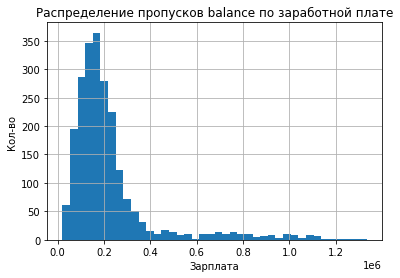

In [31]:
df[df['balance'].isna()]['est_salary'].hist(bins=40)
plt.title('Распределение пропусков balance по заработной плате')
plt.ylabel('Кол-во')
plt.xlabel('Зарплата')

In [32]:
df.groupby('products').agg({'user_id':'count'})

user_id
products         
0               1
1            3306
2            5099
3            1028
4             474
5              19

In [33]:
df[df['balance'].isna()].groupby('products').agg({'user_id':'count'})

user_id
products         
0               1
1            1921
2             310
3              28

In [34]:
round(df[df['balance'].isna()].groupby('products').agg({'user_id':'count'}) / df.groupby('products').agg({'user_id':'count'}), 2)

user_id
products         
0            1.00
1            0.58
2            0.06
3            0.03
4             NaN
5             NaN

58% клиентов с пропусками "balance" обладают лишь одним продуктом

In [35]:
df.groupby('city').agg({'user_id':'count'})

user_id
city              
Ростов        1417
Рыбинск       2654
Ярославль     5856

In [36]:
df[df['balance'].isna()].groupby('city').agg({'user_id':'count'})

user_id
city              
Ростов         235
Рыбинск        576
Ярославль     1449

In [37]:
round(df[df['balance'].isna()].groupby('city').agg({'user_id':'count'}) / df.groupby('city').agg({'user_id':'count'}), 2)

user_id
city              
Ростов        0.17
Рыбинск       0.22
Ярославль     0.25

Нет явного перевеса по городам по пропускам balance

In [38]:
df[df['balance'].isna()].groupby('churn').agg({'user_id':'count'})

user_id
churn         
0         2247
1           13

In [39]:
df.groupby('equity').agg({'user_id':'count'})

user_id
equity         
0          2554
1           772
2          1046
3          1533
4          1841
5          1911
6           161
7            79
8            17
9            13

In [40]:
df[df['balance'].isna()].groupby('equity').agg({'user_id':'count'})

user_id
equity         
0          2145
1           114
3             1

In [41]:
round(df[df['balance'].isna()].groupby('equity').agg({'user_id':'count'}) / df.groupby('equity').agg({'user_id':'count'}), 2)

user_id
equity         
0          0.84
1          0.15
2           NaN
3          0.00
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN

84% строк с кол-вом баллов собственности равным 0 имеют пропуски в balacne

Возможно у клиентов, имеющих 0 баллов собственности не собирается информация о балансе или она скрыта самим клиентом

In [42]:
df[df['balance'].isna()].groupby('gender').agg({'user_id':'count'}) / df.groupby('gender').agg({'user_id':'count'})

user_id
gender          
Ж       0.201211
М       0.254023

Пропусков у мужского пола на 5% больше 

In [43]:
df[df['balance'].isna()].groupby('credit_card').agg({'user_id':'count'}) / df.groupby('credit_card').agg({'user_id':'count'})

user_id
credit_card          
0            0.131215
1            0.273077

В 2 раза больше пропусков у держателей кредитных карт

In [44]:
df[df['balance'].isna()].groupby(['credit_card', 'products']).agg({'user_id':'count'}) / df.groupby(['credit_card', 'products']).agg({'user_id':'count'})

user_id
credit_card products          
0           0         1.000000
            1         0.768889
            2         0.029843
            3         0.019520
            4              NaN
1           1         0.551471
            2         0.079335
            3         0.041436
            4              NaN
            5              NaN

Большой процент пропусков содержится, как у пользователей с одним продуктом - НЕ держателями кредитных карт, так и у пользователей владельцами кредитных карт

In [45]:
df[df['balance'].isna()].groupby('last_activity').agg({'user_id':'count'}) / df.groupby('last_activity').agg({'user_id':'count'})

user_id
last_activity          
0              0.215433
1              0.238792

Пропуски balance почти в одинаковой доле содератся у активных и неактивных клиентов

Text(0.5, 0, 'Зарплата')

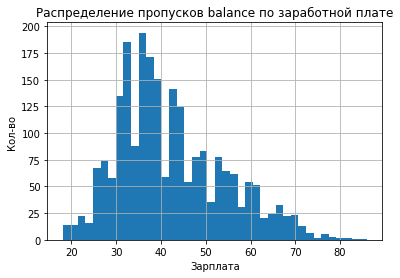

In [46]:
df[df['balance'].isna()]['age'].hist(bins=40)

plt.title('Распределение пропусков balance по заработной плате')
plt.ylabel('Кол-во')
plt.xlabel('Зарплата')

Text(0.5, 0, 'Зарплата')

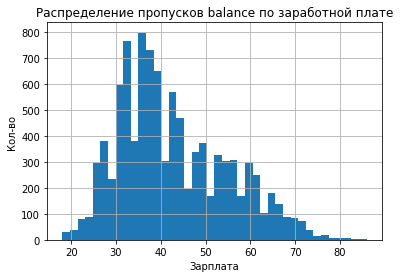

In [47]:
df['age'].hist(bins=40)
plt.title('Распределение пропусков balance по заработной плате')
plt.ylabel('Кол-во')
plt.xlabel('Зарплата')

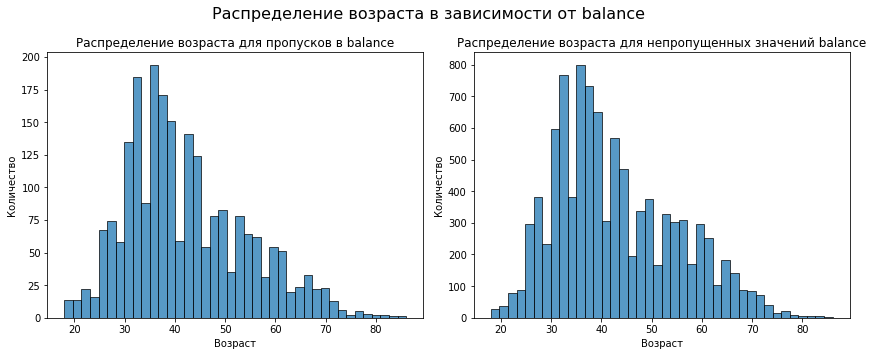

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df[df['balance'].isna()]['age'], bins=40, ax=ax1)
ax1.set_title('Распределение возраста для пропусков в balance')
ax1.set_ylabel('Количество')
ax1.set_xlabel('Возраст')

sns.histplot(df['age'], bins=40, ax=ax2)
ax2.set_title('Распределение возраста для непропущенных значений balance')
ax2.set_ylabel('Количество')
ax2.set_xlabel('Возраст')

fig.suptitle('Распределение возраста в зависимости от balance', fontsize=16)

# Выведите графики
plt.tight_layout()
plt.show()

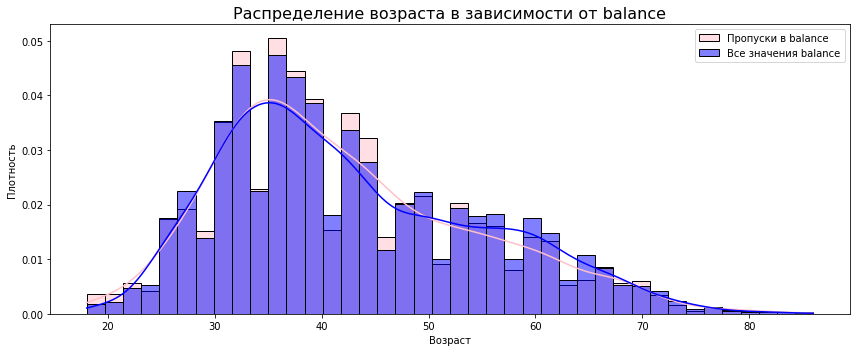

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))

# Распределение возраста для пропусков в balance
sns.histplot(
    df[df['balance'].isna()]['age'], 
    color='pink',
    bins=40, 
    ax=ax, 
    alpha=0.5, 
    label='Пропуски в balance', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
)

sns.histplot(
    df['age'],
    color='blue',
    bins=40, 
    ax=ax, 
    alpha=0.5, 
    label='Все значения balance', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax.legend()
ax.set_title('Распределение возраста в зависимости от balance', fontsize=16)
ax.set_ylabel('Плотность')
ax.set_xlabel('Возраст')


# Выведите график
plt.tight_layout()
plt.show()

Идентичная плотность пропусков balance ко всем значениям в зависимости от возраста

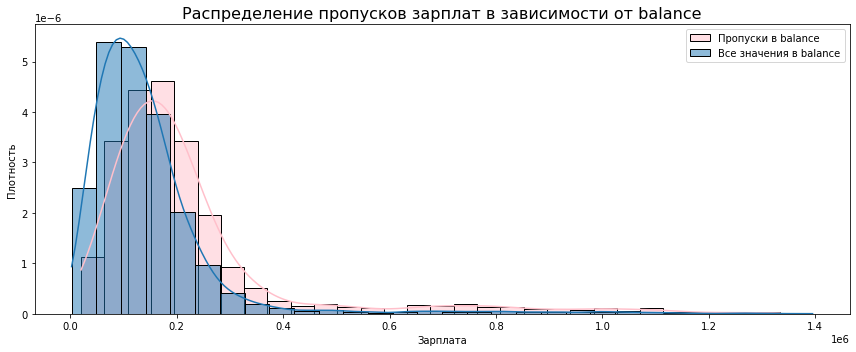

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))

# Распределение возраста для пропусков в balance
sns.histplot(
    df[df['balance'].isna()]['est_salary'],
    color='pink',
    bins=30, 
    ax=ax, alpha=0.5, 
    label='Пропуски в balance', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    df['est_salary'],
    bins=30, 
    ax=ax, alpha=0.5, 
    label='Все значения в balance', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax.legend()
ax.set_title('Распределение пропусков зарплат в зависимости от balance', fontsize=16)
ax.set_ylabel('Плотность')
ax.set_xlabel('Зарплата')


# Выведите график
plt.tight_layout()
plt.show()

Есть небольшое смещение

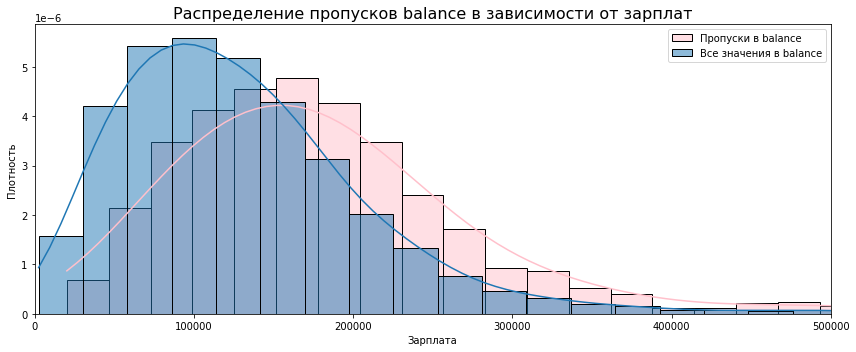

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))

# Распределение возраста для пропусков в balance
sns.histplot(
    df[df['balance'].isna()]['est_salary'],
    color='pink',
    bins=50, 
    ax=ax, alpha=0.5, 
    label='Пропуски в balance', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    df['est_salary'],
    bins=50, 
    ax=ax, alpha=0.5, 
    label='Все значения в balance', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax.legend()
ax.set_title('Распределение пропусков balance в зависимости от зарплат', fontsize=16)
ax.set_ylabel('Плотность')
ax.set_xlabel('Зарплата')
ax.set_xlim(0, 500000)

# Выведите график
plt.tight_layout()
plt.show()

Плотность пропусков у более высоких зарплат выше

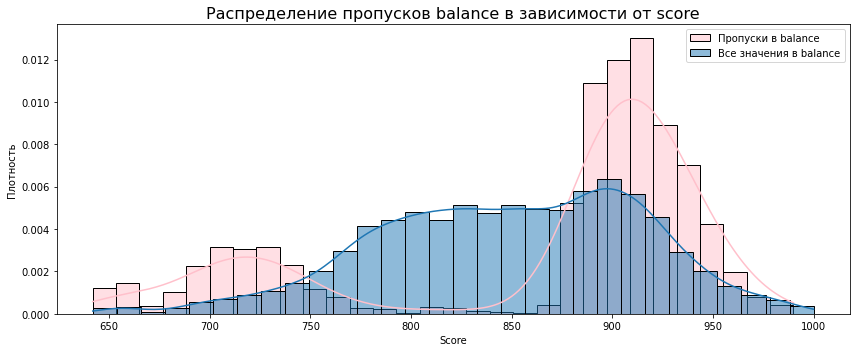

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(
    df[df['balance'].isna()]['score'],
    color='pink',
    bins=30, 
    ax=ax, alpha=0.5, 
    label='Пропуски в balance', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    df['score'],
    bins=30, 
    ax=ax, alpha=0.5, 
    label='Все значения в balance', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax.legend()
ax.set_title('Распределение пропусков balance в зависимости от score', fontsize=16)
ax.set_ylabel('Плотность')
ax.set_xlabel('Score')


plt.tight_layout()
plt.show()

Можно заметить повышенную плотность пропусков после score > 850

У клиентов с большим кредитным рейтингом доля пропусков balance больше, чем с более низким

Также не исключена возможности технических ошибок при сборе информации

### Поиск и анализ аномальных значений

In [53]:
df_old = df.copy()

In [54]:
def box_graph(name):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data = df[name]
    )
    plt.title(f"Распределение значений столбца {name}")
    plt.xlabel(name)
    plt.ylabel('Количество');

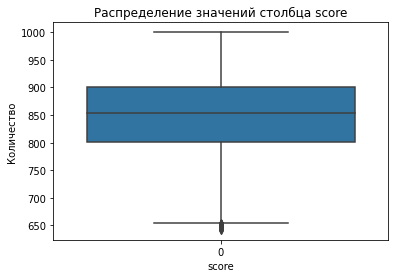

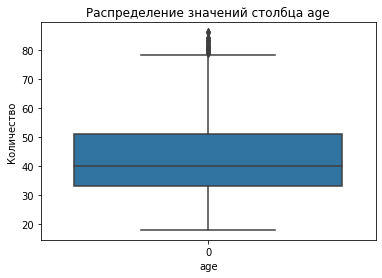

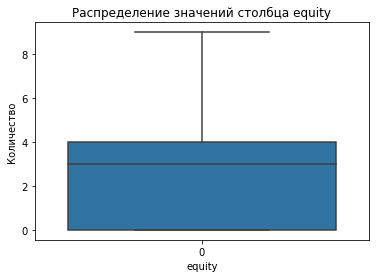

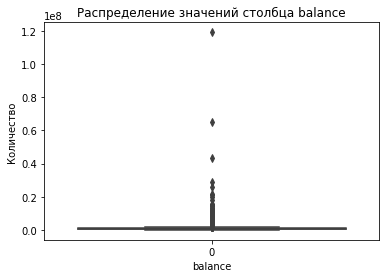

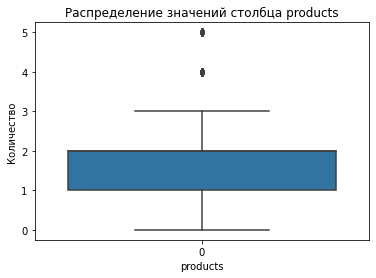

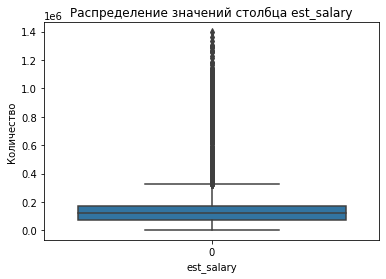

In [55]:
columns_to_plot = ['score', 'age', 'equity', 'balance', 'products', 'est_salary']

for column in columns_to_plot:
    box_graph(column)

Есть аномалии в нескольких столбцах, но все они выглядят адекватными и объяснимыми

Выделим строки с аномальными значениями столбца balance, est_salary в отдельный дата-фрейм

In [56]:
df.head(1)

user_id  score     city gender   age  equity   balance  products  \
0   183012  850.0  Рыбинск      Ж  25.0       1  59214.82         2   

   credit_card  last_activity  est_salary  churn  
0            0              1    75719.14      1

In [57]:
anomaly_range_balance = np.quantile(df['balance'].dropna(), 0.75) + 1.5 * (np.quantile(df['balance'].dropna(), 0.75) - np.quantile(df['balance'].dropna(), 0.25))

In [58]:
anomaly_range_balance

2009112.0975000001

In [59]:
anomaly_range_salary = np.quantile(df['est_salary'].dropna(), 0.75) +  1.5 * (np.quantile(df['est_salary'].dropna(), 0.75) - np.quantile(df['est_salary'].dropna(), 0.25))

In [60]:
anomaly_range_salary

323805.5424999999

In [61]:
df_anomaly = df.copy()

In [62]:
df_anomaly = df.loc[(df['balance'] > anomaly_range_balance) | (df['est_salary'] > anomaly_range_salary)]


In [63]:
round(df_anomaly['user_id'].count() /  df['user_id'].count(), 2)

0.08

8% строк являются строками или с большой зарплатой, или с большим балансом

In [64]:
df['user_id'].count()

9927

In [65]:
df = df[~df['user_id'].isin(df_anomaly['user_id'])]

## Исследовательский анализ

### Категоризация данных по столбцам "score" и "Количеству продуктов"

По шкале кредитного рейтинга проведена категоризация столбца score

🔳 1–595 — очень плохой. Шанс на одобрение крайне мал;

🔳 596–765 — плохой. Вряд ли возможно получение кредита в банке, но можно попытать счастья в МФО;

🔳 766–895 — средний. Есть шанс получить одобрение в банке;

🔳 896–950 — хороший. Многие банки оформят кредит;

🔳 951–999 — очень хороший. Вероятность того, что банк откажет, очень низкая.

In [66]:
def score_category(row):
    if row['score'] <= 595:
        return 'очень плохой'
    elif row['score'] <= 765:
        return 'плохой'
    elif row['score'] <= 895:
        return 'средний'
    elif row['score'] <= 950:
        return 'хороший'
    else:
        return 'очень хороший'


In [67]:
df['score_category'] = df.apply(score_category, axis=1)

In [68]:
df_anomaly['score_category'] = df_anomaly.apply(score_category, axis=1)

In [69]:
score_category_counts = df['score_category'].value_counts()

In [70]:
color_palette = sns.color_palette("pastel")

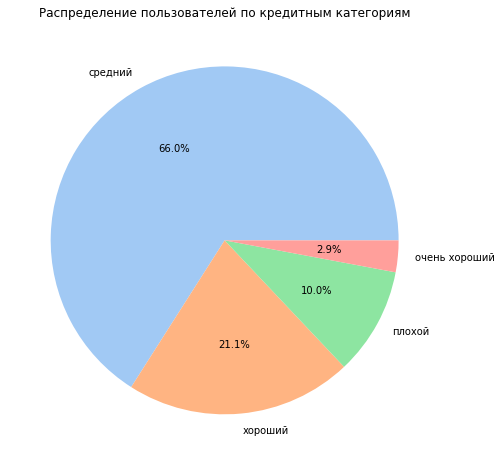

In [71]:
plt.figure(figsize=(8, 8))
plt.pie(
    score_category_counts,
    labels=score_category_counts.index,
    colors = color_palette,
    autopct='%1.1f%%'
)
plt.title('Распределение пользователей по кредитным категориям')
plt.show()

- Подавляющее большинство клиентов входят в кредитный рейтинг "средний" (66%)
- 21.1% "хороший"
- 10% "плохой"
- лишь 2.9% клиентов имеют рейтинг "очень хороший"
- в дата-сете не представлено клиентов с очень плохим рейтингом

In [72]:
df_anomaly.head()

user_id  score       city gender   age  equity     balance  products  \
18   136651  876.0  Ярославль      М  40.0       5  2307947.36         2   
30   155730  946.0  Ярославль      Ж  47.0       0         NaN         2   
44   210313  935.0  Ярославль      М  41.0       5  3781118.22         2   
59   227642  930.0  Ярославль      Ж  36.0       0         NaN         2   
63   140749  948.0  Ярославль      Ж  34.0       5  3134788.66         2   

    credit_card  last_activity  est_salary  churn score_category  
18            0              0   287010.61      0        средний  
30            1              1   660015.85      0        хороший  
44            1              0   761349.20      0        хороший  
59            1              0   359081.73      0        хороший  
63            0              0   199705.32      0        хороший

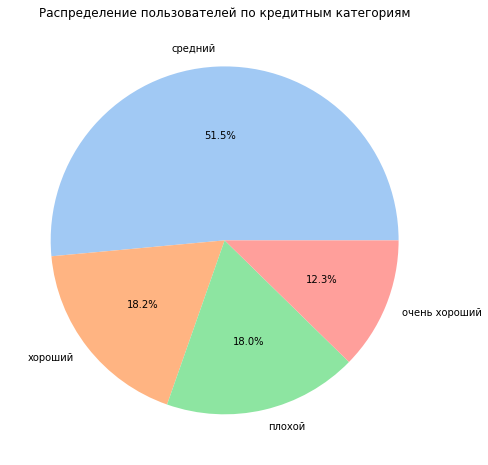

In [73]:
plt.figure(figsize=(8, 8))
plt.pie(
    df_anomaly['score_category'].value_counts(),
    labels=score_category_counts.index,
    colors = color_palette,
    autopct='%1.1f%%'
)
plt.title('Распределение пользователей по кредитным категориям')
plt.show()

В аномальном дата-сете почти 51.5% имеют средниую кредитную категорию

Хороший - 18.2%


In [74]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn score_category  
0            0              1    75719.14      1        средний  
1            1              0    86621.77      0        средний  
2            1              1   107683.34      0        средний  
3            0              1   174423.53      1        средний  
4            1              0    67353.16      1         плохой

In [75]:
df['products'].describe()

count    9140.000000
mean        1.864333
std         0.777302
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: products, dtype: float64

In [76]:
df['products'].median()

2.0

In [77]:
df[df['products'] == 0]

user_id  score     city gender   age  equity  balance  products  \
8957   147837  962.0  Рыбинск      Ж  79.0       3      NaN         0   

      credit_card  last_activity  est_salary  churn score_category  
8957            0              0    25063.96      1  очень хороший

In [78]:
df = df[df['products'] != 0]

In [79]:
def products_category(row):
    if row['products'] <= 1:
        return 'один'
    elif row['products'] <= 2:
        return 'два'
    else:
        return 'от 3 до 5'


In [80]:
df['products_category'] = df.apply(products_category, axis=1)

In [81]:
df_anomaly['products_category'] = df_anomaly.apply(products_category, axis=1)

In [82]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn score_category  \
0            0              1    75719.14      1        средний   
1            1              0    86621.77      0        средний   
2            1              1   107683.34      0        средний   
3            0              1   174423.53      1        средний   
4            1              0    67353.16      1         плохой   

  products_category  
0               два  
1         от 3 до 5  
2              один  
3               два  
4              один

По полученным данным добавим новый категориальный столбец, основанный на кол-ве продуктов клиента
1) "один" - в данную группу входят клиенты, имеющие всего один продукт банка

2) "два" - самая распространенная категория, в неё будут входить клиенты с 2мя продукатми банка

3) "от 3 до 5" категория, в которой клиенты имеют от 3 до 5 продуктов

По моему мнению, данное распределение примерно в равной степени отображает распределения по данному показателю


Мое мнение основано на пропорциональности групп. Другая категоризация приведет к слишком большому укрупнению другой группы, или наоборот группа может стать слишком малочисленной

In [83]:
products_category = df['products_category'].value_counts()

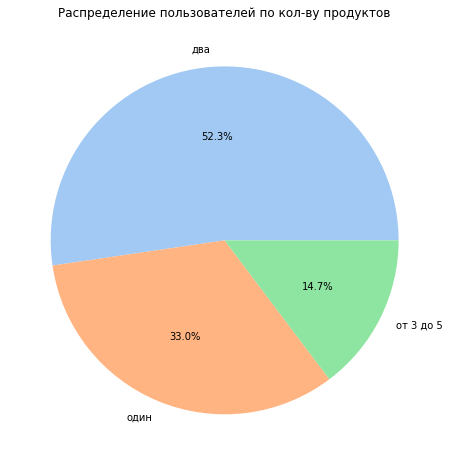

In [84]:
plt.figure(figsize=(8, 8))
plt.pie(
    products_category,
    labels=products_category.index,
    colors = color_palette,
    autopct='%1.1f%%'
)
plt.title('Распределение пользователей по кол-ву продуктов')
plt.show()

### Составление портрета пользоваетля в целом и портретов по категориям

In [85]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn score_category  \
0            0              1    75719.14      1        средний   
1            1              0    86621.77      0        средний   
2            1              1   107683.34      0        средний   
3            0              1   174423.53      1        средний   
4            1              0    67353.16      1         плохой   

  products_category  
0               два  
1         от 3 до 5  
2              один  
3               два  
4              один

In [86]:
fig = px.histogram(df, x='age', nbins=30, labels={'age': 'Возраст'})
fig.update_traces(histnorm='percent')

fig.update_layout(
    title='Гистограмма распределения возраста',
    xaxis_title='Возраст',
    yaxis_title='%',
    bargap=0.05  
)

fig.show()

In [87]:
df['age'].describe()

count    9136.000000
mean       42.624453
std        12.248416
min        18.000000
25%        33.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

In [88]:
df['age'].median()

40.0

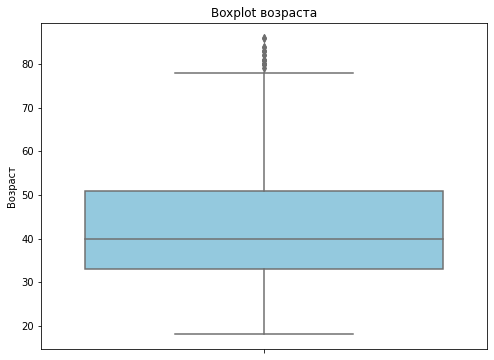

In [89]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='age', color='skyblue')
plt.title('Boxplot возраста')
plt.ylabel('Возраст')
plt.show()


- Медианный возраст клиента банка - 40 лет
- Половина клиентов банка расположена в диапозоне 33 до 51
- Самый возрастной клинет - 86 лет

In [90]:
fig = px.histogram(df_anomaly, x='age', nbins=30, labels={'age': 'Возраст'})
fig.update_traces(histnorm='percent')

fig.update_layout(
    title='Гистограмма распределения возраста',
    xaxis_title='Возраст',
    yaxis_title='%',
    bargap=0.05  
)

fig.show()

In [91]:
df_anomaly['age'].describe()

count    786.000000
mean      43.900763
std       11.188498
min       23.000000
25%       35.000000
50%       41.000000
75%       52.000000
max       80.000000
Name: age, dtype: float64

In [92]:
df_anomaly['age'].median()

41.0

В аномальном дата-фрейме средний возраст клиента выше

Возраст 50% клиентов от 35 до 52 лет

In [93]:
df['city'].value_counts()

Ярославль    5281
Рыбинск      2487
Ростов       1371
Name: city, dtype: int64

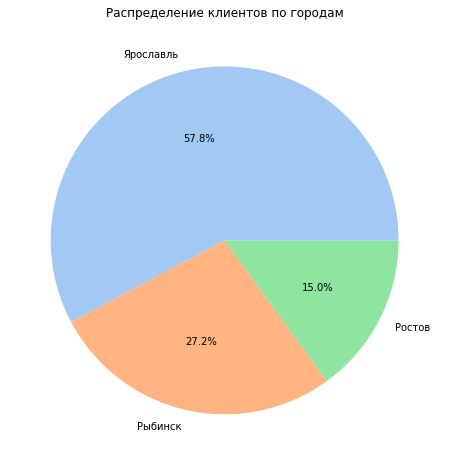

In [94]:
plt.figure(figsize=(8, 8))
plt.pie(
    df['city'].value_counts(),
    labels=df['city'].value_counts().index,
    colors = color_palette,
    autopct='%1.1f%%'
)
plt.title('Распределение клиентов по городам')
plt.show()

Большинство клиентов банка проживают в Ярослевле (57.8%)

в Рыбинске - 27.2%, Ростове - 15%


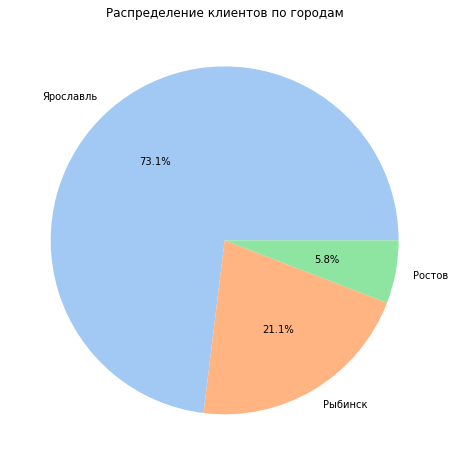

In [95]:
plt.figure(figsize=(8, 8))
plt.pie(
    df_anomaly['city'].value_counts(),
    labels=df['city'].value_counts().index,
    colors = color_palette,
    autopct='%1.1f%%'
)
plt.title('Распределение клиентов по городам')
plt.show()

В аномальном дата сете 73.1% клиентов проживают в Ярославле

Ярославль - крупный город, поэтому его доля выше в аномальном датасете из-за более высоких зарплат

In [96]:
fig = px.histogram(df, x='est_salary', nbins=30, labels={'est_salary': 'Зарплата'})

fig.update_layout(
    title='Гистограмма распределения зарплаты',
    xaxis_title='Количество',
    yaxis_title='Зарплата',
    bargap=0.05  
)

fig.show()

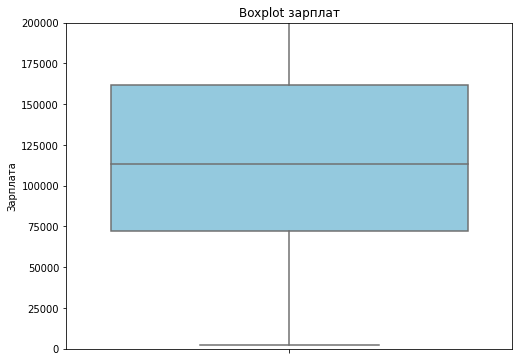

In [97]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='est_salary', color='skyblue')
plt.title('Boxplot зарплат')
plt.ylabel('Зарплата')
plt.ylim(0, 200000)  
plt.show()

In [98]:
df['est_salary'].describe()

count      9139.000000
mean     120963.076314
std       63703.150075
min        2546.300000
25%       71948.565000
50%      113124.210000
75%      161658.100000
max      323502.280000
Name: est_salary, dtype: float64

In [99]:
df['est_salary'].median()

113124.21

Средняя зарпалата клиента - 120963 тыс; Медианная - 113 тыс.

50% зарплат находятся в промежутке от 71 до 161 тыс.

In [100]:
df_anomaly['est_salary'].describe()

count    7.870000e+02
mean     4.607516e+05
std      3.027303e+05
min      2.176576e+04
25%      2.213893e+05
50%      3.590817e+05
75%      6.674906e+05
max      1.395064e+06
Name: est_salary, dtype: float64

In [101]:
df_anomaly['est_salary'].median()

359081.73

Средняя зарпалата аномального дата-фрейма у клиентов - 460 тыс; Медианная - 359 тыс.

50% зарплат находятся в промежутке от 221 до 667 тыс.

In [102]:
round(df['credit_card'].mean(), 2)

0.69

Примерно 69% клиентов имеют кредитную карту

In [103]:
round(df_anomaly['credit_card'].mean(), 2)

0.62

В аномальном сегмента примерно 62% клиентов имеют кредитную карту

In [104]:
df['equity'].describe()

count    9139.000000
mean        2.631798
std         1.956968
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: equity, dtype: float64

In [105]:
round(df['equity'].median(), 2)

3.0

75% клиентов имеют до 4 баллов недвижимости

Средний балл недвижимости 2.63

In [106]:
df_anomaly['equity'].describe()

count    787.00000
mean       2.66709
std        2.22431
min        0.00000
25%        0.00000
50%        3.00000
75%        5.00000
max        8.00000
Name: equity, dtype: float64

In [107]:
round(df_anomaly['equity'].median(), 2)

3.0

В аномальном дата-фрейме показатели схожи

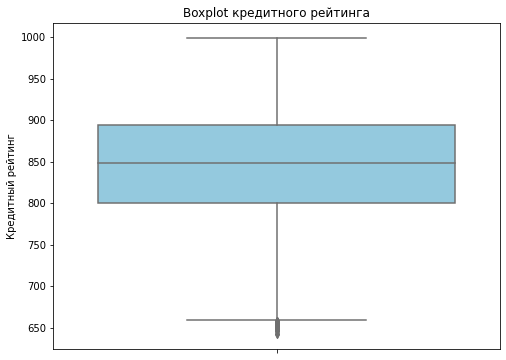

In [108]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='score', color='skyblue')
plt.title('Boxplot кредитного рейтинга')
plt.ylabel('Кредитный рейтинг')
# plt.ylim(0, 200000)  
plt.show()

In [109]:
df['score'].describe()

count    9139.000000
mean      844.658606
std        62.968441
min       642.000000
25%       800.000000
50%       848.000000
75%       894.000000
max       999.000000
Name: score, dtype: float64

In [110]:
df['score'].median()

848.0

У клиентов средний и медианный кредитный рейтинг равен 844 и 844 соответственно

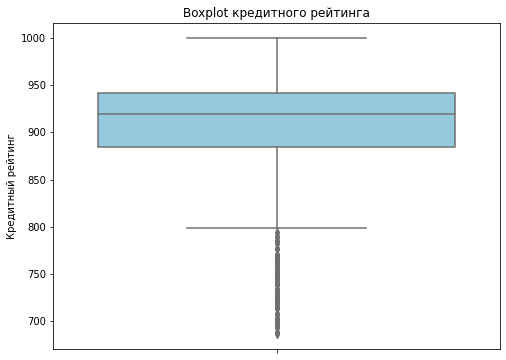

In [111]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_anomaly, y='score', color='skyblue')
plt.title('Boxplot кредитного рейтинга')
plt.ylabel('Кредитный рейтинг')
# plt.ylim(0, 200000)  
plt.show()

In [112]:
df_anomaly['score'].describe()

count     787.000000
mean      895.940280
std        73.921768
min       686.000000
25%       884.500000
50%       919.000000
75%       942.000000
max      1000.000000
Name: score, dtype: float64

In [113]:
df_anomaly['score'].median()

919.0

В аномальном дата-сете показатели чуть выше. Средний - 895, медианный 919

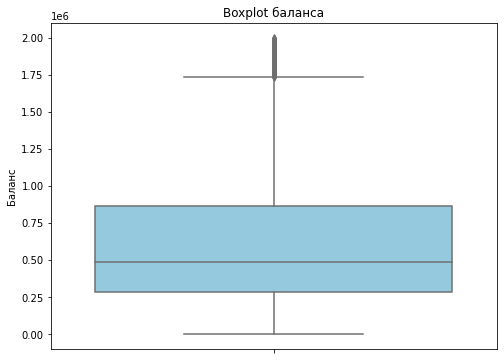

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='balance', color='skyblue')
plt.title('Boxplot баланса')
plt.ylabel('Баланс')
# plt.ylim(0, 200000)  
plt.show()

In [115]:
df['balance'].describe()

count    7.176000e+03
mean     6.111333e+05
std      4.289969e+05
min      0.000000e+00
25%      2.855946e+05
50%      4.870352e+05
75%      8.670345e+05
max      1.999799e+06
Name: balance, dtype: float64

In [116]:
df['balance'].median()

487035.16500000004

Медианный баланс клиента - 487 тыс. Средний = 611 тыс.

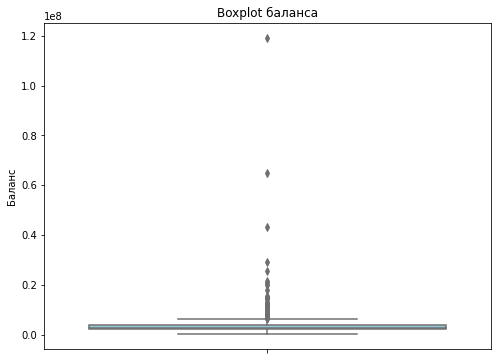

In [117]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_anomaly, y='balance', color='skyblue')
plt.title('Boxplot баланса')
plt.ylabel('Баланс')
# plt.ylim(0, 200000)  
plt.show()

In [118]:
df_anomaly['balance'].describe()

count    4.910000e+02
mean     4.011601e+06
std      6.936982e+06
min      6.610384e+04
25%      2.179002e+06
50%      2.738332e+06
75%      3.864203e+06
max      1.191136e+08
Name: balance, dtype: float64

In [119]:
df_anomaly['balance'].median()

2738332.34

В аномальном дата-сете баланс гораздо выше. Средний 4011 тыс, медианный - 2738 тыс.

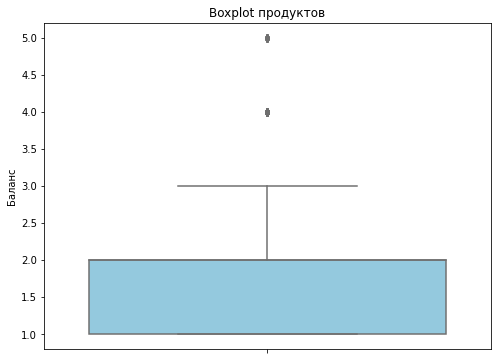

In [120]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='products', color='skyblue')
plt.title('Boxplot продуктов')
plt.ylabel('Баланс')
# plt.ylim(0, 200000)  
plt.show()

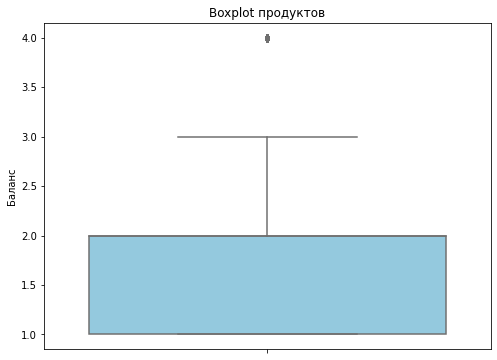

In [121]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_anomaly, y='products', color='skyblue')
plt.title('Boxplot продуктов')
plt.ylabel('Баланс')
# plt.ylim(0, 200000)  
plt.show()

В обоих дата-сетах большинство пользователей имеют до 3 продуктов

In [122]:
df['last_activity'].describe()

count    9139.000000
mean        0.522048
std         0.499541
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: last_activity, dtype: float64

In [123]:
df_anomaly['last_activity'].describe()

count    787.000000
mean       0.541296
std        0.498609
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: last_activity, dtype: float64

Процент активных клиентов одинаково распределен в обоих дата-сетах (около 53%)

In [124]:
df['churn'].describe()

count    9139.000000
mean        0.173104
std         0.378358
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

In [125]:
df_anomaly['churn'].describe()

count    787.000000
mean       0.301144
std        0.459047
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: churn, dtype: float64

Процент оттока у клиентов из обычного дата-сета равен 17; у аномального он выше: 30%

### Кор. анализ
    - Кор. анализ отдельных столбцов (score, equity, balance, products) с остальыми столбцами (показателями)
    - Кор. анализ оттока клиентов со всеми столбцами (показателями)
    

In [126]:
def gen_num(raw):
    if raw['gender'] == 'М':
        return 1
    else:
        return 2

In [127]:
df['gender_number'] = df.apply(gen_num, axis=1)

In [128]:
df_anomaly['gender_number'] = df_anomaly.apply(gen_num, axis=1)

In [129]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn score_category  \
0            0              1    75719.14      1        средний   
1            1              0    86621.77      0        средний   
2            1              1   107683.34      0        средний   
3            0              1   174423.53      1        средний   
4            1              0    67353.16      1         плохой   

  products_category  gender_number  
0               два              2  
1         от 3 до 5              2  
2              один              2  
3               два              2  
4              один              1

In [130]:
df['city1'] = df['city']

In [131]:
df_anomaly['city1'] = df_anomaly['city']

In [132]:
df = pd.get_dummies(df, columns=['city1'])

In [133]:
df_anomaly = pd.get_dummies(df_anomaly, columns=['city1'])

In [134]:
df_cor = df.copy()

In [135]:
df_cor1 = df_anomaly.copy()

In [136]:
df_cor.drop('user_id', axis=1, inplace=True)

In [137]:
df_cor1.drop('user_id', axis=1, inplace=True)

In [138]:
df_cor = df_cor.corr()

In [139]:
df_cor1 = df_cor1.corr()

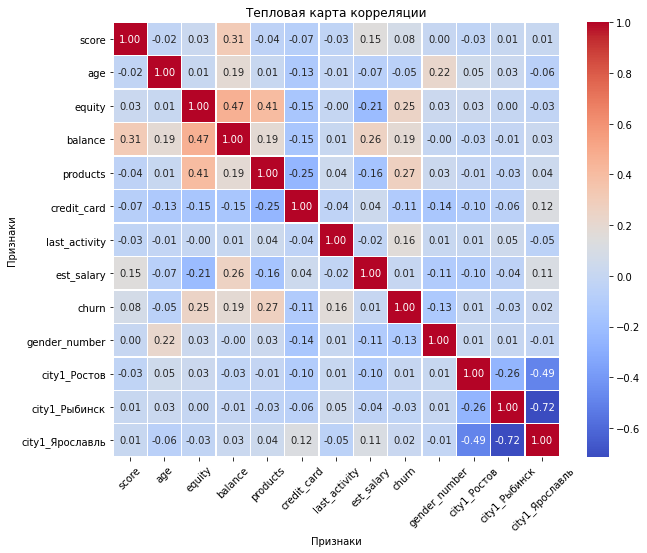

In [140]:
plt.figure(figsize=(10, 8))  
sns.heatmap(df_cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.title('Тепловая карта корреляции')
plt.xticks(rotation=45)

plt.show()

Отток клиентов имеет умеренную корреляцию с признакми "products", слабую с  "equity"

Также "proucts" умеренно коррелирует с признаком "equity"; а 'balance' с 'balance'

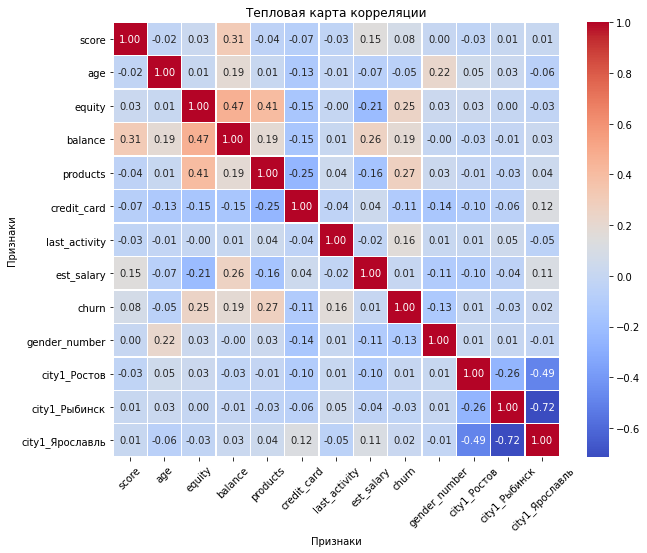

In [141]:
plt.figure(figsize=(10, 8))  
sns.heatmap(df_cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.title('Тепловая карта корреляции')
plt.xticks(rotation=45)

plt.show()

### Построение графиков, показывающие распределение оттока
- Гистограмма оттока
- Столбчатые диаграммы
и др


In [142]:
print(f"{round(df['churn'].sum() / df['user_id'].count() * 100, 2)}%")


17.31%


17.31% - процент оттока клиентов по всему дата фрейму

In [143]:
print(f"{round(df_anomaly['churn'].sum() / df_anomaly['user_id'].count() * 100, 2)}%")


30.11%


30.11% - процент оттока клиентов по аномальному дата-фрейму

In [144]:
city_churn = df.groupby('city').agg({'churn':'sum', 'user_id':'count'}).sort_values(by='churn',ascending=False).reset_index()
city_churn['perc'] = round(city_churn['churn'] / city_churn['user_id'], 2) * 100

In [145]:
city_churn1 = df_anomaly.groupby('city').agg({'churn':'sum', 'user_id':'count'}).sort_values(by='churn',ascending=False).reset_index()
city_churn1['perc'] = round(city_churn1['churn'] / city_churn1['user_id'], 2) * 100

In [146]:
city_churn1

city  churn  user_id  perc
0  Ярославль    170      575  30.0
1    Рыбинск     47      166  28.0
2     Ростов     20       46  43.0

In [147]:
city_churn

city  churn  user_id  perc
0  Ярославль    947     5281  18.0
1    Рыбинск    389     2487  16.0
2     Ростов    246     1371  18.0

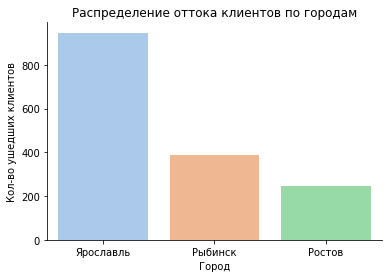

In [148]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=city_churn,
    y='churn', 
    x='city',
    palette = color_palette
)
sns.despine()
ax.set_title('Распределение оттока клиентов по городам')
ax.set_xlabel('Город')
ax.set_ylabel('Кол-во ушедших клиентов');

Ярославль имеет самое большое кол-во отточных клиентов в сравнении с другими гордами. Это связано с тем, что в Ярославле проживает большее кол-во клиентов

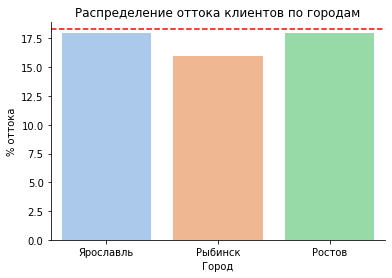

In [149]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=city_churn,
    y='perc', 
    x='city',
    palette = color_palette
)
sns.despine()
ax.set_title('Распределение оттока клиентов по городам')
ax.set_xlabel('Город')
ax.set_ylabel('% оттока');
ax.axhline(y=18.33, color='red', linestyle='--')

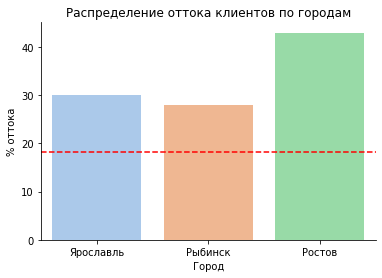

In [150]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=city_churn1,
    y='perc', 
    x='city',
    palette = color_palette
)
sns.despine()
ax.set_title('Распределение оттока клиентов по городам')
ax.set_xlabel('Город')
ax.set_ylabel('% оттока');
ax.axhline(y=18.33, color='red', linestyle='--')

В Ростове виден большоей отток клиентов из аномального дата-сета

In [151]:
churn_by_gender = df.groupby('gender').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn', ascending=False).reset_index()

In [152]:
churn_by_gender['perc'] = round(churn_by_gender['churn'] / churn_by_gender['user_id'] * 100, 2)

In [153]:
churn_by_gender1 = df_anomaly.groupby('gender').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn', ascending=False).reset_index()

In [154]:
churn_by_gender1['perc'] = round(churn_by_gender1['churn'] / churn_by_gender1['user_id'] * 100, 2)

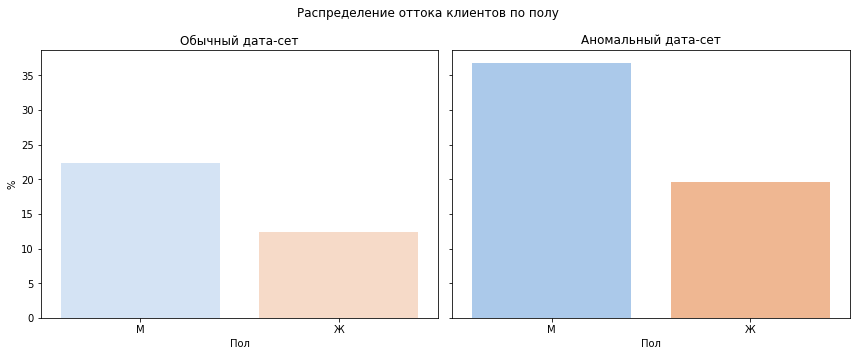

In [155]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

sns.barplot(
    data=churn_by_gender,
    ax=ax1,
    y='perc',
    alpha=0.5,
    x='gender',
    palette=color_palette
)

sns.barplot(
    data=churn_by_gender1,
    ax=ax2,
    y='perc',
    x='gender',
    palette=color_palette
)

fig.suptitle('Распределение оттока клиентов по полу')

ax1.set_title('Обычный дата-сет')
ax1.set_ylabel('%')
ax1.set_xlabel('Пол')

ax2.set_title('Аномальный дата-сет')
ax2.set_ylabel('')
ax2.set_xlabel('Пол')


plt.tight_layout()
plt.show()

Можно сказать, что клиенты мужского пола имеют гораздо больший процент оттока в сравнении с женским

In [156]:
piv1 = df.pivot_table(index='city', columns='gender', values='churn', aggfunc='mean')

In [157]:
piv1 = piv1.sort_values(by='gender', ascending=False, axis=1)

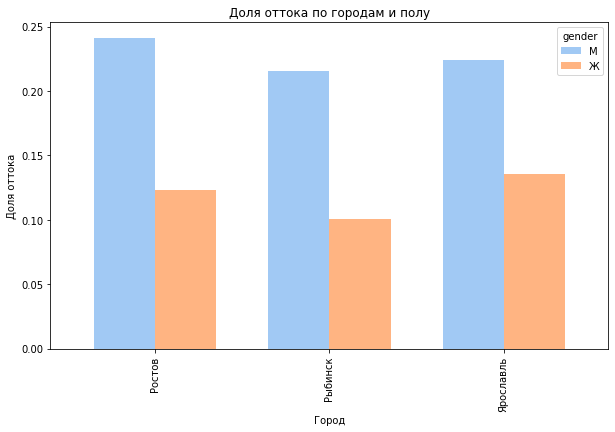

In [158]:
piv1.plot(kind='bar', figsize=(10, 6), width = 0.7, color=color_palette)
plt.title('Доля оттока по городам и полу')
plt.xlabel('Город')
plt.ylabel('Доля оттока')
plt.show()

По всем городам видна одинаковая тенденция. У мужского пола отток выше

In [159]:
churn_by_score = df.groupby('score_category').agg({'user_id':'count','churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [160]:
churn_by_score1 = df_anomaly.groupby('score_category').agg({'user_id':'count','churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [161]:
churn_by_score['churn'] = round(churn_by_score['churn'] * 100, 2)

In [162]:
churn_by_score1['churn'] = round(churn_by_score1['churn'] * 100, 2)

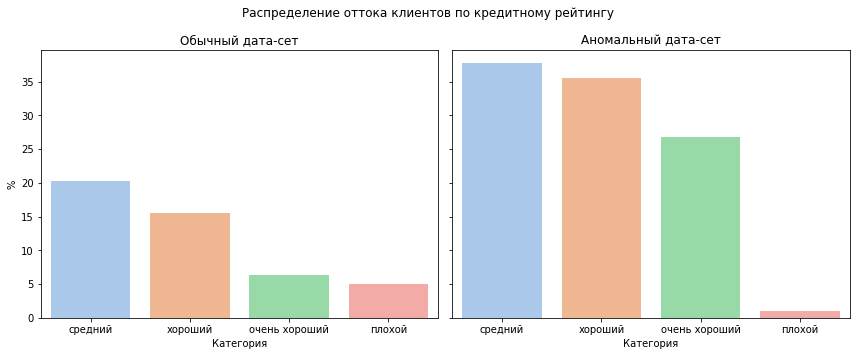

In [163]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

sns.barplot(
    ax=ax1,
    data=churn_by_score,
    y='churn', 
    x='score_category',
    palette = color_palette
)
sns.barplot(
    ax=ax2,
    data=churn_by_score1,
    y='churn', 
    x='score_category',
    palette = color_palette
)

fig.suptitle('Распределение оттока клиентов по кредитному рейтингу')

ax1.set_title('Обычный дата-сет')
ax1.set_ylabel('%')
ax1.set_xlabel('Категория')

ax2.set_title('Аномальный дата-сет')
ax2.set_ylabel('')
ax2.set_xlabel('Категория')


plt.tight_layout()
plt.show()

По графику видно, что категория "средний" и "хороший" имеют отток больше, чем категории "очень хороший", "плохой" в обычном дата сете 

В аномальном дата-сете по всем категориям наблддается большой отток, кроме категории "плохой"

In [164]:
churn_by_product = df.groupby('products_category').agg({'user_id':'count','churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [165]:
churn_by_product1 = df_anomaly.groupby('products_category').agg({'user_id':'count','churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [166]:
churn_by_product['churn'] = round(churn_by_product['churn'] * 100, 2)

In [167]:
churn_by_product1['churn'] = round(churn_by_product1['churn'] * 100, 2)

In [168]:
churn_by_product

products_category  user_id  churn
0         от 3 до 5     1345  36.80
1               два     4781  18.11
2              один     3013   7.33

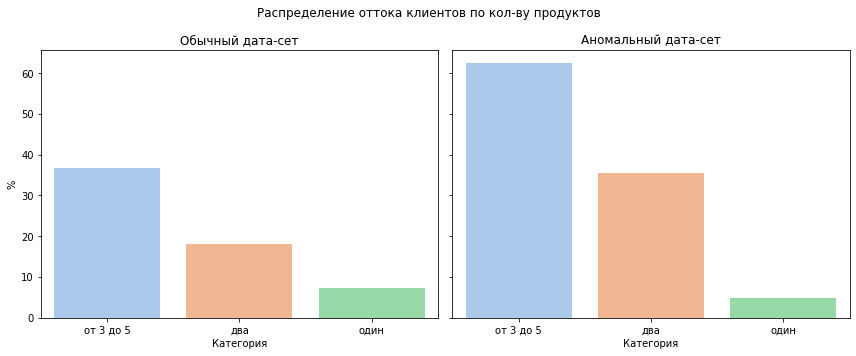

In [169]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

sns.barplot(
    ax=ax1,
    data=churn_by_product,
    y='churn', 
    x='products_category',
    palette = color_palette
)
sns.barplot(
    ax=ax2,
    data=churn_by_product1,
    y='churn', 
    x='products_category',
    palette = color_palette
)

fig.suptitle('Распределение оттока клиентов по кол-ву продуктов')

ax1.set_title('Обычный дата-сет')
ax1.set_ylabel('%')
ax1.set_xlabel('Категория')

ax2.set_title('Аномальный дата-сет')
ax2.set_ylabel('')
ax2.set_xlabel('Категория')


plt.tight_layout()
plt.show()

Категория "от 3 до 5" имеет почти в 2 раза выше отток, чем категория "два". и в 5 развыше, чем "один" в обычном дата-сете

в аномальном отток клиентов в категории "от 3 до 5" составляет 60%

In [170]:
dff1 = df[df['products'] >= 3]

In [171]:
dff11 = df_anomaly[df_anomaly['products'] >= 3]

In [172]:
dff1_by_products = dff1.groupby('products').agg({'user_id':'count', 'churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [173]:
dff1_by_products1 = dff11.groupby('products').agg({'user_id':'count', 'churn':'mean'}).sort_values(by='churn', ascending=False).reset_index()

In [174]:
dff1_by_products['churn'] = dff1_by_products['churn'] * 100

In [175]:
dff1_by_products1['churn'] = dff1_by_products1['churn'] * 100

In [176]:
dff1_by_products

products  user_id      churn
0         4      392  59.438776
1         5       19  42.105263
2         3      934  27.194861

In [177]:
dff1_by_products1

products  user_id      churn
0         4       82  81.707317
1         3       94  45.744681

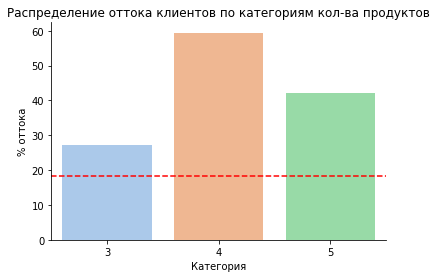

In [178]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=dff1_by_products,
    y='churn', 
    x='products',
    palette = color_palette
)
sns.despine()
ax.set_title('Распределение оттока клиентов по категориям кол-ва продуктов')
ax.set_xlabel('Категория')
ax.set_ylabel('% оттока')
ax.axhline(y=18.33, color='red', linestyle='--');

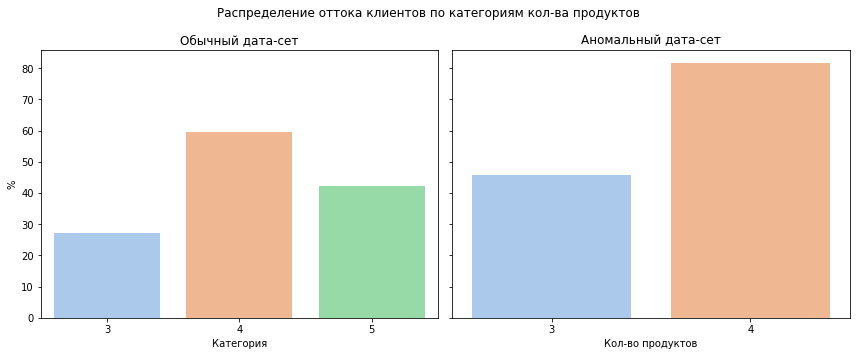

In [179]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

sns.barplot(
    ax=ax1,
    data=dff1_by_products,
    y='churn', 
    x='products',
    palette = color_palette
)
sns.barplot(
    ax=ax2,
    data=dff1_by_products1,
    y='churn', 
    x='products',
    palette = color_palette
)

fig.suptitle('Распределение оттока клиентов по категориям кол-ва продуктов')

ax1.set_title('Обычный дата-сет')
ax1.set_ylabel('%')
ax1.set_xlabel('Категория')

ax2.set_title('Аномальный дата-сет')
ax2.set_ylabel('')
ax2.set_xlabel('Кол-во продуктов')


plt.tight_layout()
plt.show()

В обоих дата-сетах отток клиентов с 4 продуктами достаточно высокий. В обычном - 60%. В аномальном дата-сете процент оттока намного выше (4 продута - окола 80%)

In [180]:
round(df[df['products'] >= 4]['churn'].mean(), 2)

0.59

In [181]:
churn = df.copy()

In [182]:
churn = churn[churn['churn'] == 1]

In [183]:
churn1 = df_anomaly.copy()

In [184]:
churn1 = churn1[churn1['churn'] == 1]

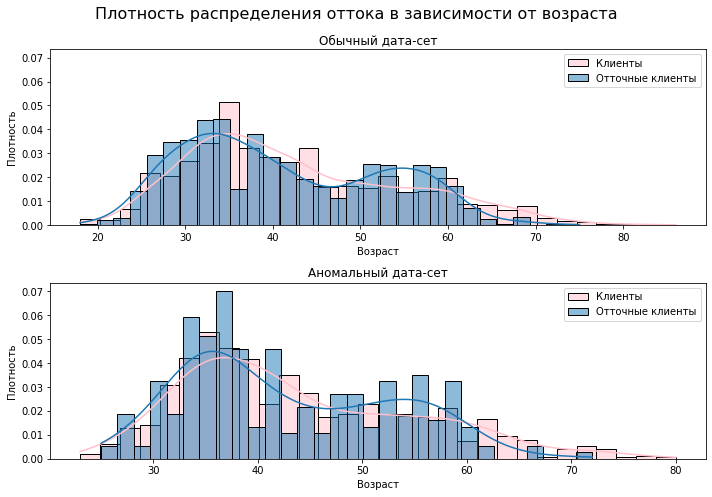

In [185]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 7), sharey=True)
# sharey=True)

sns.histplot(
    df['age'],
    color='pink',
    bins=30, 
    ax=ax1, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn['age'],
    bins=30, 
    ax=ax1, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)
fig.suptitle('Плотность распределения оттока в зависимости от возраста', fontsize=16)
ax1.legend()
ax1.set_title('Обычный дата-сет', fontsize=12)
ax1.set_ylabel('Плотность')
ax1.set_xlabel('Возраст')

sns.histplot(
    df_anomaly['age'],
    color='pink',
    bins=30, 
    ax=ax2, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn1['age'],
    bins=30, 
    ax=ax2, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax2.legend()
ax2.set_title('Аномальный дата-сет', fontsize=12)
ax2.set_ylabel('Плотность')
ax2.set_xlabel('Возраст')


# Выведите график
plt.tight_layout()
plt.show()

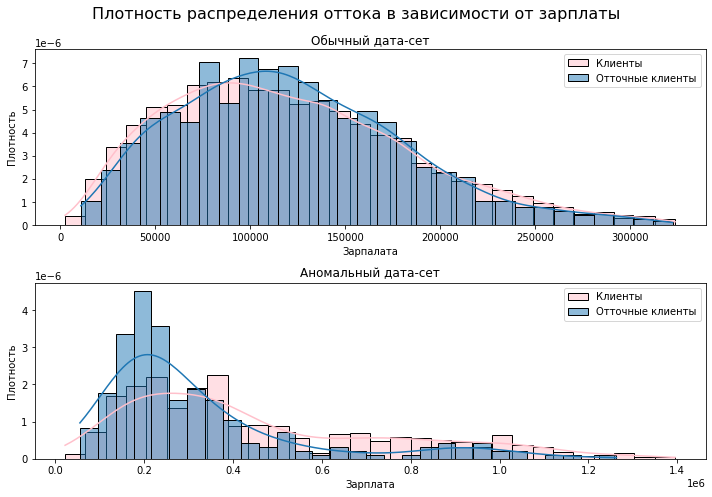

In [186]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 7))
# sharey=True)

sns.histplot(
    df['est_salary'],
    color='pink',
    bins=30, 
    ax=ax1, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn['est_salary'],
    bins=30, 
    ax=ax1, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)
fig.suptitle('Плотность распределения оттока в зависимости от зарплаты', fontsize=16)
ax1.legend()
ax1.set_title('Обычный дата-сет', fontsize=12)
ax1.set_ylabel('Плотность')
ax1.set_xlabel('Зарпалата')

sns.histplot(
    df_anomaly['est_salary'],
    color='pink',
    bins=30, 
    ax=ax2, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn1['est_salary'],
    bins=30, 
    ax=ax2, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax2.legend()
ax2.set_title('Аномальный дата-сет', fontsize=12)
ax2.set_ylabel('Плотность')
ax2.set_xlabel('Зарплата')

plt.tight_layout()
plt.show()

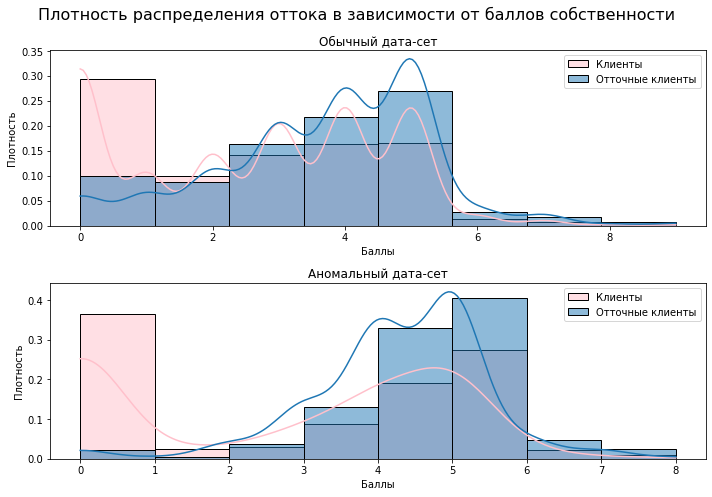

In [187]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 7))
# sharey=True)

sns.histplot(
    df['equity'],
    color='pink',
    bins=8, 
    ax=ax1, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn['equity'],
    bins=8, 
    ax=ax1, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)
fig.suptitle('Плотность распределения оттока в зависимости от баллов собственности', fontsize=16)
ax1.legend()
ax1.set_title('Обычный дата-сет', fontsize=12)
ax1.set_ylabel('Плотность')
ax1.set_xlabel('Баллы')

sns.histplot(
    df_anomaly['equity'],
    color='pink',
    bins=8, 
    ax=ax2, alpha=0.5, 
    label='Клиенты', 
    kde=True,
    stat="density", 
    common_norm=False,
    legend=True
    
)

sns.histplot(
    churn1['equity'],
    bins=8, 
    ax=ax2, alpha=0.5, 
    label='Отточные клиенты', 
    kde=True, 
    stat="density", 
    common_norm=False,
    legend=True
)

ax2.legend()
ax2.set_title('Аномальный дата-сет', fontsize=12)
ax2.set_ylabel('Плотность')
ax2.set_xlabel('Баллы')

plt.tight_layout()
plt.show()

Видна тендеция оттока клиентов с большим кол-вом баллов собственности

In [188]:
credit_count = df.groupby('credit_card').agg({'user_id':'count'}).reset_index()

In [189]:
credit_count1 = df_anomaly.groupby('credit_card').agg({'user_id':'count'}).reset_index()

In [190]:
credit_count_ch = churn.groupby('credit_card').agg({'user_id':'count'}).reset_index()

In [191]:
credit_count_ch1 = churn1.groupby('credit_card').agg({'user_id':'count'}).reset_index()

Доля ушедших клиентов без кредитной карты выше, чем с её наличием у клиентов

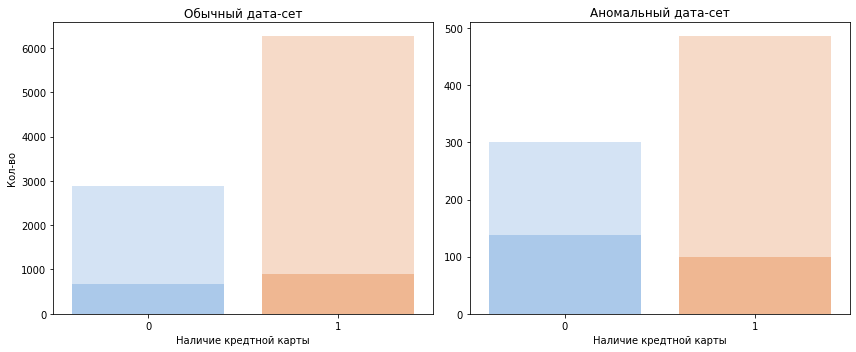

In [192]:
ig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
# sharey=True)

sns.barplot(
    ax=ax1,
    alpha=0.5,
    data=credit_count,
    y='user_id', 
    x='credit_card',
    palette = color_palette
    
)

sns.barplot(
    ax=ax1,
    data=credit_count_ch,
    y='user_id', 
    x='credit_card',
    palette = color_palette
)


ax1.set_title('Обычный дата-сет', fontsize=12)
ax1.set_ylabel('Кол-во')
ax1.set_xlabel('Наличие кредтной карты')

sns.barplot(
    ax=ax2,
    alpha=0.5,
    data=credit_count1,
    y='user_id', 
    x='credit_card',
    palette = color_palette
    
)

sns.barplot(
    ax=ax2,
    data=credit_count_ch1,
    y='user_id', 
    x='credit_card',
    palette = color_palette
)
ax2.set_title('Аномальный дата-сет', fontsize=12)
ax2.set_ylabel('')
ax2.set_xlabel('Наличие кредтной карты')

fig.suptitle('Распределение оттока клиентов по наличию кредитной карты', fontsize=16)

# Выведите график
plt.tight_layout()
plt.show()

In [193]:
active_count = df.groupby('last_activity').agg({'user_id':'count'}).reset_index()

In [194]:
active_count1 = df_anomaly.groupby('last_activity').agg({'user_id':'count'}).reset_index()

In [195]:
active_count_ch = churn.groupby('last_activity').agg({'user_id':'count'}).reset_index()

In [196]:
active_count_ch1 = churn.groupby('last_activity').agg({'user_id':'count'}).reset_index()

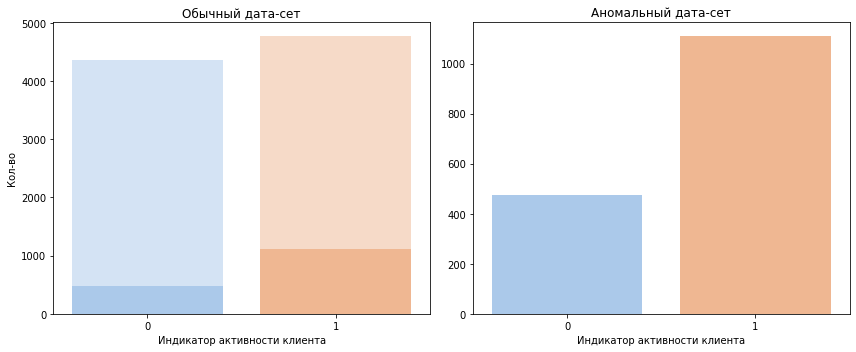

In [197]:
ig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
# sharey=True)

sns.barplot(
    ax=ax1,
    alpha=0.5,
    data=active_count,
    y='user_id', 
    x='last_activity',
    palette = color_palette
    
)

sns.barplot(
    ax=ax1,
    data=active_count_ch,
    y='user_id', 
    x='last_activity',
    palette = color_palette
)


ax1.set_title('Обычный дата-сет', fontsize=12)
ax1.set_ylabel('Кол-во')
ax1.set_xlabel('Индикатор активности клиента')

sns.barplot(
    ax=ax2,
    alpha=0.5,
    data=active_count1,
    y='user_id', 
    x='last_activity',
    palette = color_palette
    
)

sns.barplot(
    ax=ax2,
    data=active_count_ch1,
    y='user_id', 
    x='last_activity',
    palette = color_palette
)

ax2.set_title('Аномальный дата-сет', fontsize=12)
ax2.set_ylabel('')
ax2.set_xlabel('Индикатор активности клиента')

fig.suptitle('Распределение оттока клиентов по индикатору активности клиента', fontsize=16)

# Выведите график
plt.tight_layout()
plt.show()

активные клиенты уходят чаще

### Выводы после исследовательского анализа

- В городе Ярославль находится большинство клиентов банка
- Клиенты были разделеы на 2 дата сета:
    - С нормальным балансом и зарплатой
    - С аномальным балансо или зарплатой
- По кредитной категории
    - В обычном дата сете 66% клиентов имеют средний кредитный рейтинг, 21% хороший
    - В аномальном 515% имеют средний рейтинг, 18.2% хороший, 18% плохой
- Половина клиентов банка расположена в диапозоне 33 до 51 лет
- Средняя зарпалата клиента:
    - В обычном дата-сете 120 тыс.
    - В аномельном 359 тыс
- Более половины всех клиентов из обоих дата-сетов проживают в Ярославле

    
   

### Проверка Стат. гипотез:

Необходимо произвести сегментацию пользователей по кол-ву продуктов и другими категориями, например, категории столбца "score"

- 1:**Проверим, есть ли стат. значимая разница в доле ушедших клиентов по всей таблицы с долей по каждой категории из столбца "score"**
    - H0: Доля ушедших клиентов по всей таблице и в каждой из категорий "score" одинакова
    - H1: Доля ушедших клиентов по всей таблице и в каждой из категорий "score" различна
    
- 2: **Проверим, есть ли стат. значимая разница в доле ушедших клиентов по всей таблицы с долей по каждой категории из из столбца с кол-вом имеющихся продуктов**. Также можно проверить гипотезу не по сегметам продукта, а по каждому из возможных значений в столбце products
    - H0: Доля ушедших клиентов в каждом сегменте по кол-ву продуктов одинакова с долей ушедших клиентов по всей таблице
    - H1: Доля ушедших клиентов в каждом сегменте по кол-ву продуктов различна с долей ушедших клиентов по всей таблице
    
Далее провериются все составленные гипотезы

In [198]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn score_category  \
0            0              1    75719.14      1        средний   
1            1              0    86621.77      0        средний   
2            1              1   107683.34      0        средний   
3            0              1   174423.53      1        средний   
4            1              0    67353.16      1         плохой   

  products_category  gender_number  city1_Ростов  city1_Рыбинск  \
0               два              2             0              1   
1         от 3 до 5              2             0              1   
2              один              2             0              1   
3               два              2             0              0   
4              один              1             0              0   

   city1_Ярославль  
0                0  
1                0  
2                0  
3                1  
4                1

In [199]:
z1 = df.groupby('score_category').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn',ascending=False)

In [200]:
z11 = df_anomaly.groupby('score_category').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn',ascending=False)

In [201]:
z1 = z1[z1['churn'] >= 30]

In [202]:
z11 = z11[z11['churn'] >= 30]

In [204]:
index1 = z1.index

In [205]:
index11 = z11.index

In [206]:
z1_val = z1.values

In [207]:
z11_val = z11.values

In [208]:
z1_val

array([[6030, 1221],
       [1926,  298],
       [ 915,   46]])

In [209]:
z2 = df.groupby('products').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn',ascending=False)

In [210]:
z22 = df_anomaly.groupby('products').agg({'user_id':'count', 'churn':'sum'}).sort_values(by='churn',ascending=False)

In [212]:
z2 = z2.reset_index()

In [213]:
z22 = z22.reset_index()

In [214]:
z2 = z2.query('user_id > 30')

In [215]:
z22 = z22.query('user_id > 30')

In [216]:
z2 

products  user_id  churn
0         2     4781    866
1         3      934    254
2         4      392    233
3         1     3013    221

In [217]:
z2_val = z2[['user_id', 'churn']].values

In [218]:
z22_val = z22[['user_id', 'churn']].values

удалим из стат анализа клиентов с 5 и 0 продуктов из-за их малого кол-ва. Z-test можно проводить от 30 наблюдений

In [219]:
index2 = z2['products']

In [220]:
index22 = z22['products']

In [221]:
def z_t(ar, ind):
    for i in range(1, len(ar)):
        for j in range(i, len(ar)):
            nobs = [ar[i-i][0], ar[j][0]]
            count = [ar[i-i][1], ar[j][1]]
            stat, pval = proportions_ztest(count, nobs)
            print('{0:0.4f}'.format(pval))
            if pval < alpha:
                print(f"Отвергаем нулевую гипотезу: между долей отточных клиентов категории '{ind[i-1]}'  ко доле '{ind[j]}' есть значимая разница")
            else:
                print(f"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  '{ind[i-1]}'  ко доле '{ind[j]}'  разными")

Всего будет проведено 12 тестов.
Необхдимо произвести поправку множественных сравнений


In [222]:
alpha = 0.05

In [223]:
alpha = round(alpha / 18, 4)

In [224]:
alpha

0.0028

**Проверим, есть ли стат. значимая разница в доле ушедших клиентов по всей таблицы с долей по каждой категории из столбца "score"**

    - H0: Доля ушедших клиентов из категории n и m столбца "score" одинакова
    - H1: Доля ушедших клиентов из категории n и m столбца "score" различна

In [225]:
index1

Index(['средний', 'хороший', 'плохой'], dtype='object', name='score_category')

In [226]:
z_t(z1_val, index1)

0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории 'средний'  ко доле 'хороший' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории 'средний'  ко доле 'плохой' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории 'хороший'  ко доле 'плохой' есть значимая разница


In [227]:
z_t(z11_val, index11)

0.6368
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  'хороший'  ко доле 'средний'  разными
0.0556
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  'хороший'  ко доле 'очень хороший'  разными
0.0556
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  'средний'  ко доле 'очень хороший'  разными


В обычном дата сете есть стат значимая разница между кредитными категориями, в аномальном - нет

**Проверим, есть ли стат. значимая разница в доле ушедших клиентов по всей таблицы с долей по каждой категории из из столбца с кол-вом имеющихся продуктов**. 

    - H0: Доля ушедших клиентов n сегмента с долей m сегмента одинакова
    - H1: Доля ушедших клиентов n сегмента с долей m сегмента различна

In [228]:
z_t(z2_val, index2)

0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '2'  ко доле '3' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '2'  ко доле '4' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '2'  ко доле '1' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '3'  ко доле '4' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '3'  ко доле '1' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '4'  ко доле '1' есть значимая разница


In [229]:
z_t(z22_val, index22)

0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '2'  ко доле '4' есть значимая разница
0.0730
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  '2'  ко доле '3'  разными
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '2'  ко доле '1' есть значимая разница
0.0730
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли отточных клиентов категории  '4'  ко доле '3'  разными
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '4'  ко доле '1' есть значимая разница
0.0000
Отвергаем нулевую гипотезу: между долей отточных клиентов категории '3'  ко доле '1' есть значимая разница


По кол-ву продуктов все доли оттока клиентов являются разными, кроме доли 4 к 3

### Сегментация на основе данных из предыдущих пунктов

по результатам предыдущих пунктов можно увидеть "проблемные сегменты":

    - Клиенты мужского полаимеют процент оттока выше, чем у женского
    - Клиенты с кол-вом продуктов больше 3х в обоих дата-сетах.
    - В целом по аномальному дата-сету видна денденция оттока выше,чем у обыкновенного. В аномальный дата-фрейм попали клиенты или с аномальным балансом, или с аномальной зарплатой.

Состваим следующие сегменты:

- Сегмент 1 (1804 чел.) - клиенты из Ярославля, обладающие одним продуктом
- Сегмент 2 (2240 чел.) - клиенты мужского пола, обладающие 2мя продуктами
- сегмент 3 (2541 чел.) - клиенты женского пола, обладающие 2мя продуктами
- Сегмент 4 (1345 чел.) - клиенты, обладающие от 3 до 5 продуктами 
- Сегмент 5 (494 чел.) - клиенты аномального дата-сета, кроме клиентов обладающих одним продуктом

In [230]:
seg1 = df[(df['products'] == 1) & (df['city'] == 'Ярославль')]

In [231]:
seg1['user_id'].count()

1804

In [232]:
seg2 = df[(df['products'] == 2) & (df['gender'] == 'М')]

In [233]:
seg2['user_id'].count()

2240

In [234]:
seg3 = df[(df['products'] == 2) & (df['gender'] == 'Ж')]

In [235]:
seg3['user_id'].count()

2541

In [236]:
seg4 = df[df['products'] >= 3]

In [237]:
seg4['user_id'].count()

1345

In [238]:
seg5 = df_anomaly[df_anomaly['products'] != 1]

In [239]:
seg5['user_id'].count()

494

In [240]:
(seg1['user_id'].count() + \
seg2['user_id'].count() + \
seg3['user_id'].count() + \
seg4['user_id'].count() + \
seg5['user_id'].count()) / df_old['user_id'].count()

0.8485947416137806

In [241]:
for i in seg1.columns:
    print(i)
    print(seg1[i].describe())
    print('-------------------')

user_id
count      1804.000000
mean     171734.162417
std       33573.959137
min       97604.000000
25%      142113.250000
50%      172167.000000
75%      201403.500000
max      229145.000000
Name: user_id, dtype: float64
-------------------
score
count    1804.000000
mean      853.935698
std        78.322642
min       646.000000
25%       801.000000
50%       884.500000
75%       912.000000
max       997.000000
Name: score, dtype: float64
-------------------
city
count          1804
unique            1
top       Ярославль
freq           1804
Name: city, dtype: object
-------------------
gender
count     1804
unique       2
top          М
freq       973
Name: gender, dtype: object
-------------------
age
count    1804.000000
mean       41.467295
std        11.739289
min        18.000000
25%        33.000000
50%        39.000000
75%        48.000000
max        86.000000
Name: age, dtype: float64
-------------------
equity
count    1804.000000
mean        1.292683
std         1.852501
mi

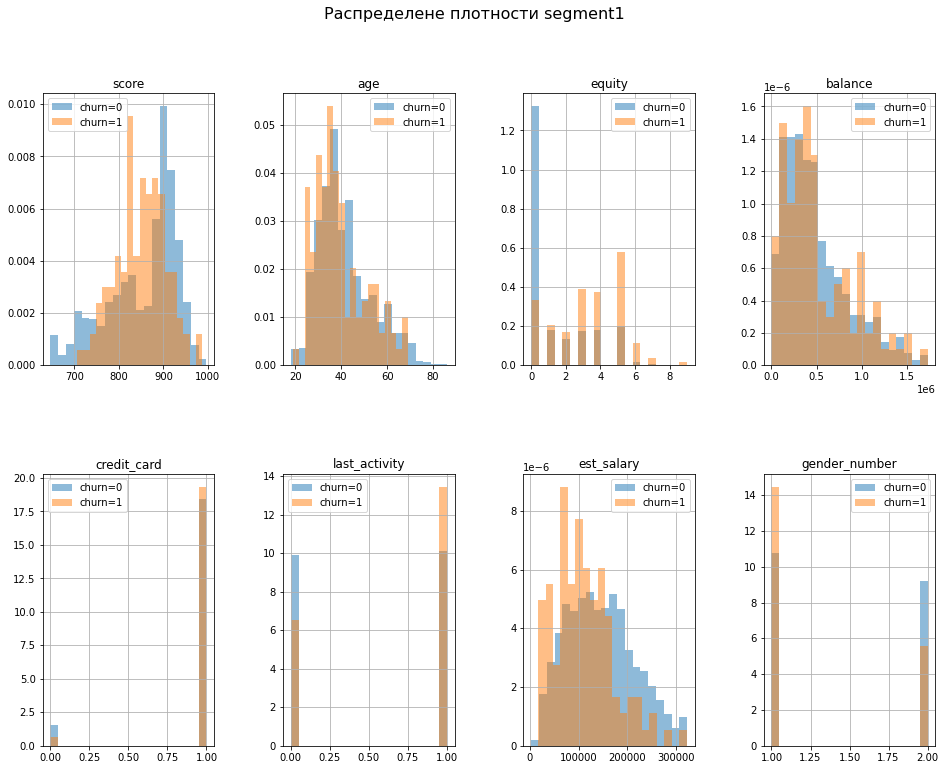

In [242]:
data_churn_0 = seg1[seg1['churn'] < 2][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]
data_churn_1 = seg1[seg1['churn'] == 1][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(data_churn_0.columns):
    ax = axes[i // 4, i % 4]
    data_churn_0[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=0')
    data_churn_1[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=1')
    ax.set_title(col)
    ax.legend()

plt.suptitle('Распределене плотности segment1', fontsize=16)
plt.show()

In [243]:
for i in seg2.columns:
    print(i)
    print(seg2[i].describe())
    print('-------------------')

user_id
count      2240.000000
mean     171721.917857
std       33669.331408
min       97131.000000
25%      142378.250000
50%      171997.500000
75%      201546.750000
max      229015.000000
Name: user_id, dtype: float64
-------------------
score
count    2240.000000
mean      838.407589
std        57.006675
min       652.000000
25%       796.000000
50%       836.000000
75%       880.000000
max       998.000000
Name: score, dtype: float64
-------------------
city
count          2240
unique            3
top       Ярославль
freq           1232
Name: city, dtype: object
-------------------
gender
count     2240
unique       1
top          М
freq      2240
Name: gender, dtype: object
-------------------
age
count    2239.000000
mean       40.040643
std        10.530421
min        18.000000
25%        32.000000
50%        38.000000
75%        47.000000
max        74.000000
Name: age, dtype: float64
-------------------
equity
count    2240.000000
mean        3.100446
std         1.732747
mi

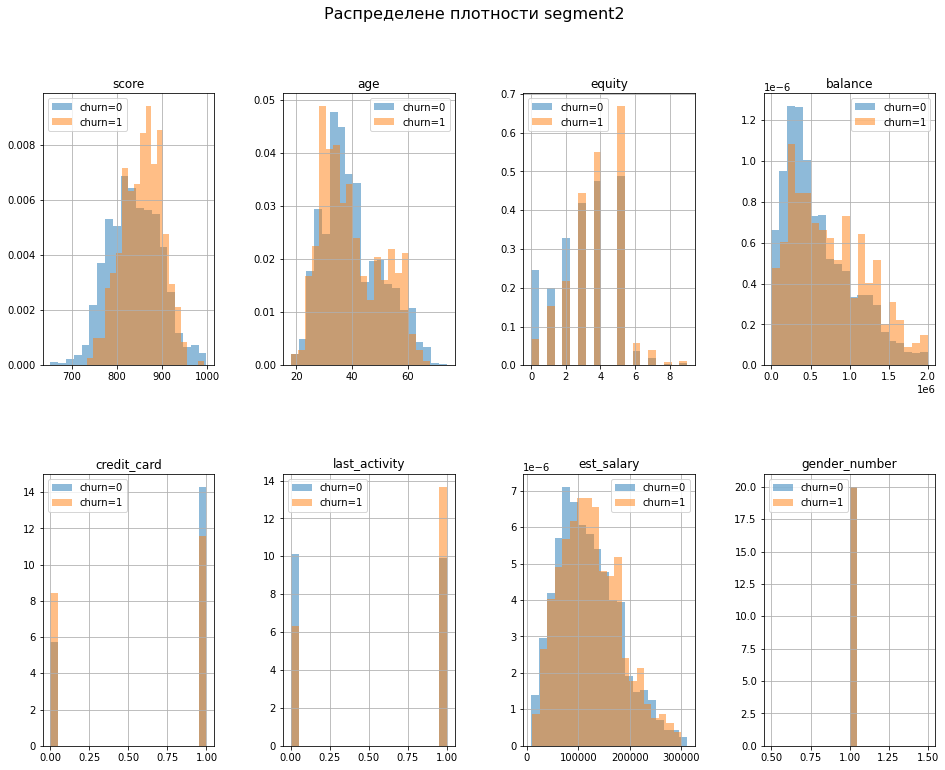

In [244]:
data_churn_2 = seg2[seg2['churn'] < 2][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]
data_churn_3 = seg2[seg2['churn'] == 1][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(data_churn_0.columns):
    ax = axes[i // 4, i % 4]
    data_churn_2[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=0')
    data_churn_3[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=1')
    ax.set_title(col)
    ax.legend()

plt.suptitle('Распределене плотности segment2', fontsize=16)
plt.show()

Сегмент 2:
- Средее значение столбца score: 838
- Средний возраст 40 года
- Средняя зарплата: 119 тыс.


По оттоку (25%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой от 100 до 150 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят реже

In [245]:
for i in seg3.columns:
    print(i)
    print(seg3[i].describe())
    print('-------------------')

user_id
count      2541.000000
mean     171125.968516
std       33788.038306
min       94561.000000
25%      141045.000000
50%      172459.000000
75%      201039.000000
max      229136.000000
Name: user_id, dtype: float64
-------------------
score
count    2541.000000
mean      842.242031
std        53.953765
min       646.000000
25%       801.000000
50%       843.000000
75%       880.000000
max       997.000000
Name: score, dtype: float64
-------------------
city
count          2541
unique            3
top       Ярославль
freq           1297
Name: city, dtype: object
-------------------
gender
count     2541
unique       1
top          Ж
freq      2541
Name: gender, dtype: object
-------------------
age
count    2539.000000
mean       45.005120
std        13.124862
min        19.000000
25%        34.000000
50%        43.000000
75%        56.000000
max        84.000000
Name: age, dtype: float64
-------------------
equity
count    2541.000000
mean        3.143251
std         1.676359
mi

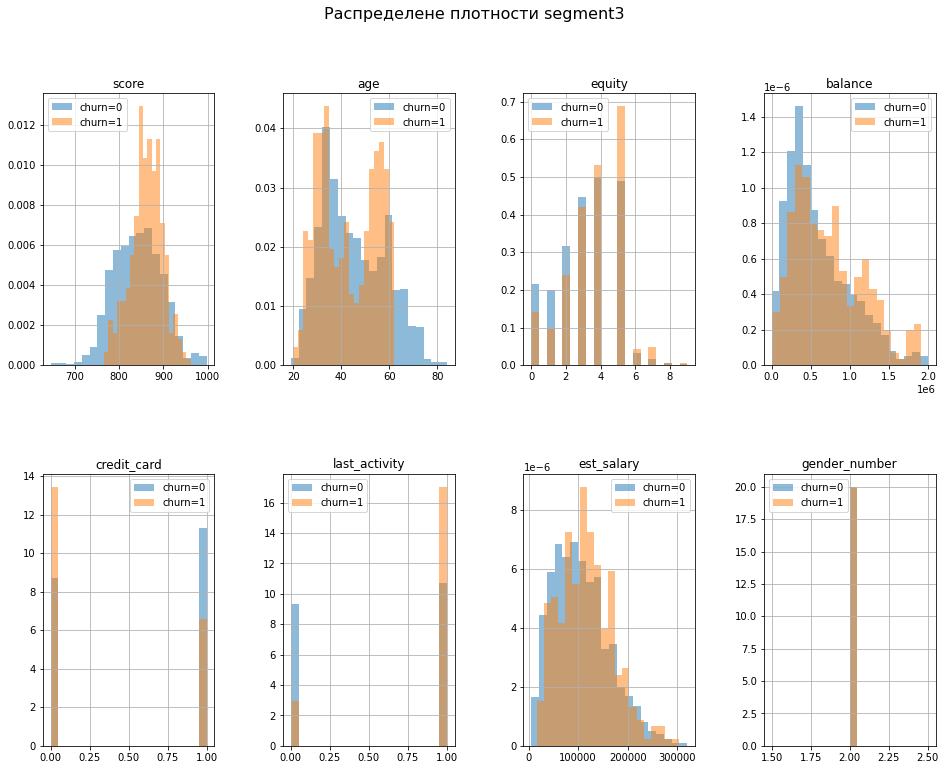

In [246]:
data_churn_4 = seg3[seg3['churn'] < 2][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]
data_churn_5 = seg3[seg3['churn'] == 1][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(data_churn_0.columns):
    ax = axes[i // 4, i % 4]
    data_churn_4[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=0')
    data_churn_5[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=1')
    ax.set_title(col)
    ax.legend()

plt.suptitle('Распределене плотности segment3', fontsize=16)
plt.show()

Сегмент 3:
- Средее значение столбца score: 842
- Средний возраст 45 года
- Средняя зарплата: 106 тыс.


По оттоку (12%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с возрастом от 55 до 60 виден больший отток
- У клиентов с зарплатой от 100 до 150 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят реже

In [247]:
for i in seg4.columns:
    print(i)
    print(seg4[i].describe())
    print('-------------------')

user_id
count      1345.000000
mean     171415.368773
std       33845.468455
min       95384.000000
25%      142939.000000
50%      173000.000000
75%      200059.000000
max      229009.000000
Name: user_id, dtype: float64
-------------------
score
count    1345.000000
mean      841.390335
std        52.105491
min       689.000000
25%       802.000000
50%       839.000000
75%       878.000000
max       996.000000
Name: score, dtype: float64
-------------------
city
count          1345
unique            3
top       Ярославль
freq            948
Name: city, dtype: object
-------------------
gender
count     1345
unique       2
top          Ж
freq       709
Name: gender, dtype: object
-------------------
age
count    1345.000000
mean       43.573978
std        12.717889
min        19.000000
25%        34.000000
50%        40.000000
75%        53.000000
max        83.000000
Name: age, dtype: float64
-------------------
equity
count    1345.000000
mean        3.649814
std         1.566498
mi

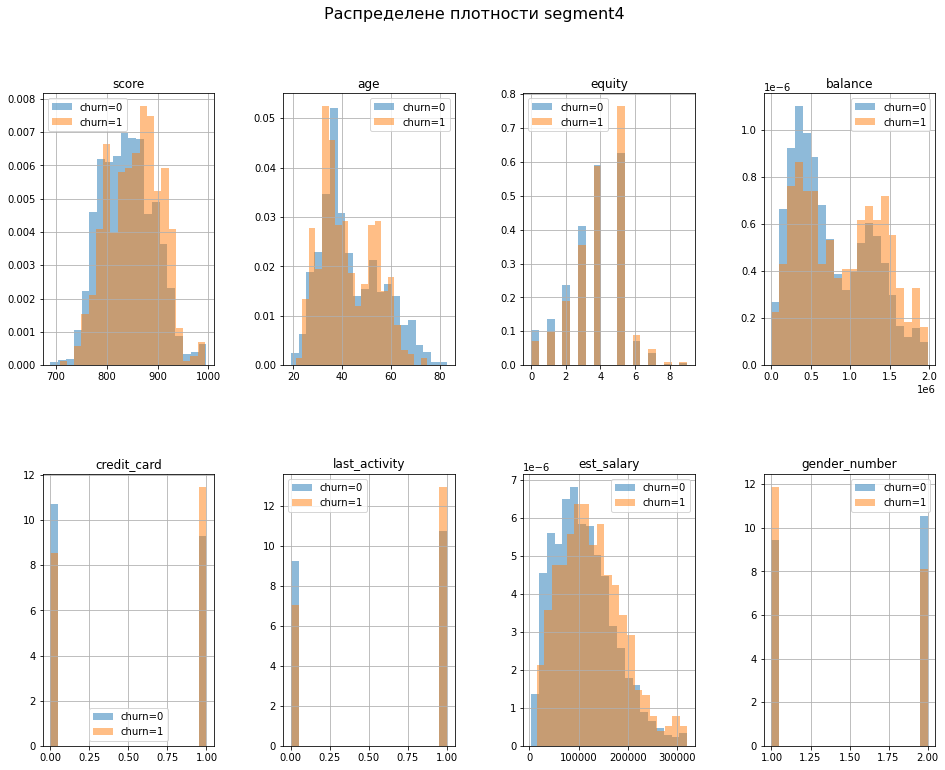

In [248]:
data_churn_6 = seg4[seg4['churn'] < 2][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]
data_churn_7 = seg4[seg4['churn'] == 1][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(data_churn_0.columns):
    ax = axes[i // 4, i % 4]
    data_churn_6[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=0')
    data_churn_7[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=1')
    ax.set_title(col)
    ax.legend()

plt.suptitle('Распределене плотности segment4', fontsize=16)
plt.show()

Сегмент 4:
- Средее значение столбца score: 841
- Средний возраст 44 года
- Средняя зарплата: 110 тыс.


По оттоку (37%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой от 150 до 200 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят чаще
- Клиенты мужского пола уходят чаще

In [249]:
for i in seg5.columns:
    print(i)
    print(seg5[i].describe())
    print('-------------------')

user_id
count       494.000000
mean     173828.730769
std       35585.400366
min       96562.000000
25%      144869.500000
50%      174152.500000
75%      204063.250000
max      229058.000000
Name: user_id, dtype: float64
-------------------
score
count     494.000000
mean      911.208502
std        53.777536
min       686.000000
25%       894.250000
50%       921.000000
75%       942.000000
max      1000.000000
Name: score, dtype: float64
-------------------
city
count           494
unique            3
top       Ярославль
freq            367
Name: city, dtype: object
-------------------
gender
count     494
unique      2
top         М
freq      309
Name: gender, dtype: object
-------------------
age
count    493.000000
mean      44.373225
std       11.071766
min       23.000000
25%       36.000000
50%       42.000000
75%       53.000000
max       78.000000
Name: age, dtype: float64
-------------------
equity
count    494.000000
mean       3.848178
std        1.637302
min        0.0000

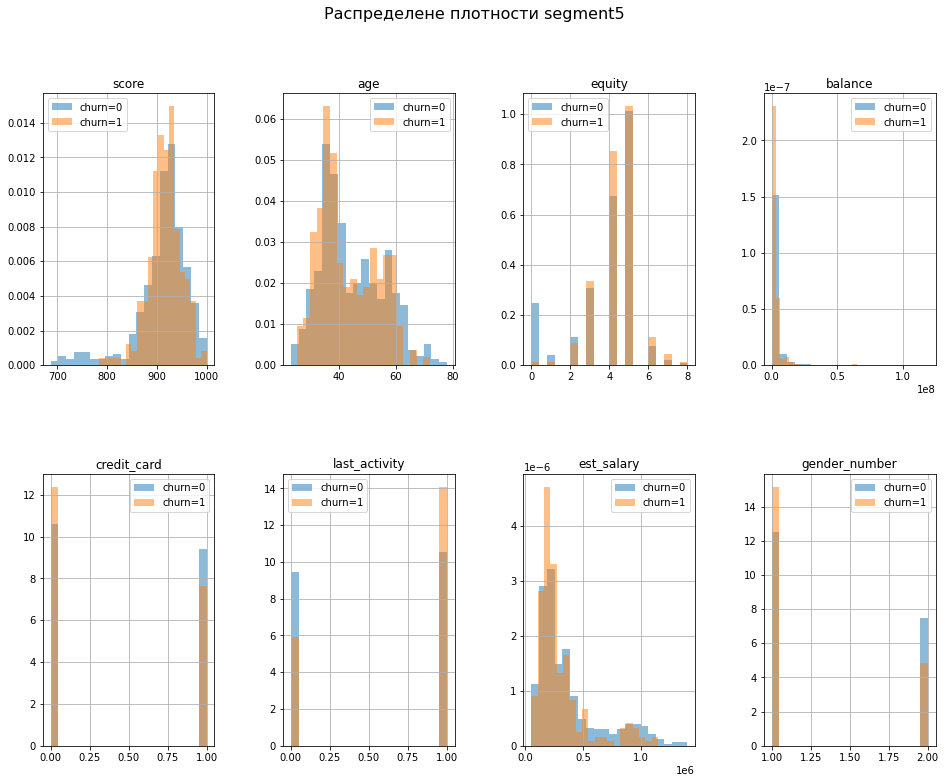

In [250]:
data_churn_8 = seg5[seg5['churn'] < 2][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]
data_churn_9 = seg5[seg5['churn'] == 1][['score', 'age', 'equity', 'balance', 'credit_card', 'last_activity', 'est_salary', 'gender_number']]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(data_churn_0.columns):
    ax = axes[i // 4, i % 4]
    data_churn_8[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=0')
    data_churn_9[col].hist(ax=ax, bins=20, density=True, alpha=0.5, label='churn=1')
    ax.set_title(col)
    ax.legend()

plt.suptitle('Распределене плотности segment5', fontsize=16)
plt.show()

Сегмент 5:
- Средее значение столбца score: 911
- Средний возраст 44 года
- Средняя зарплата: 374 тыс.


По оттоку (45%) можно сказать:
- У клиентов от 35 до 40 лет отток значительно выше
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой около 250 тыс высокий отток
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом (относительно других сегментов) 
- Владельцы кредитных карт уходят реже
- Клиенты мужского пола уходят чаще
- Активные клиенты уходят чаще

### Общий вывод об анализе оттока клиентов

 - В нормальном дата-сете лишь средняя категория имеет отток около 20%. В аномальном дата-сете категория среднийй имеет почти 35% оттока. все категрии, кроме плохой имеют отток выше 20%
    - Клиенты, обладающие одним и двумя продуктами в обчыном дата-сете имеют отток ниже 20%. В аномальном категоря 2 имеет отток выше 30%.
    - В обычном дата-сете отток у клиентов с 4 продуктами около 60%. в аномальном клиенты с 4 продуктами имеют отток около 80%
    - Видна тендеция оттока клиентов с большим кол-вом баллов собственности
    - Доля ушедших клиентов без кредитной карты выше, чем с её наличием

На основе анализа было выявлено 3 сегментов, охватывающие 85% клиентов:
- Сегмент 1 (1804 чел.) (отток 7%) - клиенты из Ярославля, обладающие одним продуктом
- Сегмент 2 (2240 чел.) (отток 25%) - клиенты мужского пола, обладающие 2мя продуктами
- Сегмент 3 (2541 чел.) (отток 12%) - клиенты женского пола, обладающие 2мя продуктами
- Сегмент 4 (1345 чел.) **проблемный** (отток 37%) - клиенты, обладающие от 3 до 5 продуктами 
- Сегмент 5 (494 чел.) **проблемный** (отток 45%) - клиенты аномального дата-сета, с кол-вом продуктов больше 1

Сегмент 1:
- Средее значение столбца score: 853
- Средний возраст 42 года
- Средняя зарплата: 145 тыс.


По оттоку (7%) можно сказать:
- У клиентов с кредитным рейтингом от 800 до 880 отток выше
- У клиентов с зарплатой до 150 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности
- Владельцы кредитных карт уходят чаще
- И у мужского пола отток выше, чем у женского

Сегмент 2:
- Средее значение столбца score: 838
- Средний возраст 40 года
- Средняя зарплата: 119 тыс.


По оттоку (25%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой от 100 до 150 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят реже\

Сегмент 3:
- Средее значение столбца score: 842
- Средний возраст 45 года
- Средняя зарплата: 106 тыс.


По оттоку (12%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с возрастом от 55 до 60 виден больший отток
- У клиентов с зарплатой от 100 до 150 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят реже

Сегмент 4:
- Средее значение столбца score: 841
- Средний возраст 44 года
- Средняя зарплата: 110 тыс.


По оттоку (37%) можно сказать:
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой от 150 до 200 тыс. отток выше
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом
- Владельцы кредитных карт уходят чаще
- Клиенты мужского пола уходят чаще

Сегмент 5:
- Средее значение столбца score: 911
- Средний возраст 44 года
- Средняя зарплата: 374 тыс.


По оттоку (45%) можно сказать:
- У клиентов от 35 до 40 лет отток значительно выше
- У клиентов с кредитным рейтингом от 850 до 900 отток выше
- У клиентов с зарплатой около 250 тыс высокий отток
- Также виден высокий отток у клиентов с большим кол-вом баллов собственности и балансом (относительно других сегментов) 
- Владельцы кредитных карт уходят реже
- Клиенты мужского пола уходят чаще
- Активные клиенты уходят чаще

**Рекомендации**:
- Компании стоит обратить внимание на клиентов с большим кол-вом продуктов
- Поощрять владельцев кредитных карт и/или улучшить качество продуктов
- Устранить причины большего оттока клиентов мужского пола
- В сегменте 4:
    - Проанализировать качество и привлекатлеьность продуктов для клиентов с большим доходом/балансом/собственностю
    - Сделать более привлекательные условия для владельцев кредитных карт
- В сегменте 5:
    - Проанализировать качество и привлекатлеьность продуктов для клиентов с большим доходом/балансом/собственностю
    - Сделать более привлекательные условия для клиентов с большим кредитным рейтином (900 и более)
    - Провести акции направленные на людей среднего возраста

**Презентация**

https://disk.yandex.lt/i/RIb6P90efVPTTQ